In [52]:
import traci
import pandas as pd
import numpy as np
import time
import traci.constants as tc
import pickle
import sumolib
import matplotlib.pyplot as plt
from collections import defaultdict
import random

In [53]:
SUMO_BINARY = "sumo-gui"
SUMO_CFG = r"C:\Users\Paulo Alexandre\Documents\PauloAlexandre\Ensino_Superior\MIA\1_Ano\1_Semestre\MS\Projeto\MS_VCI_Simulation\simulation\vci.sumocfg"  # must reference your .net.xml

In [54]:
def get_real_counts_for_day(df_day):
    """
    Aggregate TOTAL_VOLUME per arm for one day.
    Returns {arm: volume}.
    """
    g = df_day.groupby("half_arm")["TOTAL_VOLUME"].sum()
    return g.to_dict()

In [55]:
class GaussianThompsonBandit:
    """
    Simple independent Gaussian Thompson Sampling per arm.
    Reward = -loss; here we will approximate per-arm reward using
    negative squared error between sim and real volume.
    """

    def __init__(self, arms, init_mean=20.0, init_var=100.0, obs_noise_var=100.0):
        """
        arms: iterable of arm IDs (e.g., tuples (half_bin, sensor, dir))
        init_mean: prior mean for flow
        init_var:  prior variance
        obs_noise_var: assumed observation noise variance
        """
        self.arms = list(arms)
        self.obs_noise_var = obs_noise_var
        self.means = {a: init_mean for a in self.arms}
        self.vars  = {a: init_var  for a in self.arms}

    def sample_flows(self):
        """
        Sample a flow (mean vehicles) for each arm.
        Returns {arm: flow_estimate}
        """
        flows = {}
        MAX_FLOW = 7000.0
        for a in self.arms:
            mu = self.means[a]
            var = self.vars[a]

            # Sample from the normal distribution
            sample = np.random.normal(mu, np.sqrt(var))

            # FIX: Clip the value to ensure it stays within physically possible limits
            # This prevents the massive trip counts that caused the teleporting errors.
            flows[a] = np.clip(sample, 0.0, MAX_FLOW)
        return flows

    def update(self, real_counts, sim_counts, reward=None):
        """
        Update posterior given real and simulated counts for each arm.
        We treat the real volume as (noisy) observation of the mean flow.

        real_counts: {arm: real_volume}
        sim_counts:  {arm: sim_volume}
        """
        # Pick one arm to monitor (Optional)
        debug_arm = next(iter(self.arms)) if self.arms else None
        before = (self.means.get(debug_arm), self.vars.get(debug_arm)) if debug_arm else None

        # Here we only use real_counts to update the prior,
        # but you can also use the error sim - real in a more complex way.
        updated_count = 0
        for a, y in real_counts.items():
            if a in self.means:
                mu_prior = self.means[a]
                var_prior = self.vars[a]
                var_noise = self.obs_noise_var

                # Bayesian update for normal-normal model
                var_post = 1.0 / (1.0 / var_prior + 1.0 / var_noise)
                mu_post = var_post * (mu_prior / var_prior + y / var_noise)

                self.means[a] = mu_post
                self.vars[a]  = var_post
                updated_count += 1
            else:
                # This will trigger if the keys don't match
                print(f"[DEBUG] Key mismatch: {a} not found in bandit arms!")
        print(f"[BANDIT] Successfully updated {updated_count} out of {len(real_counts)} real counts.")
    
    def save(self, filepath):
        """Saves the learned means and variances to a file."""
        data = {
            'means': self.means,
            'vars': self.vars,
            'arms': self.arms,
            'obs_noise_var': self.obs_noise_var
        }
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
        print(f"[INFO] Model saved to {filepath}")

    @staticmethod
    def load(filepath):
        """Loads a saved model and returns a bandit instance."""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        
        # Reconstruct the bandit with saved state
        bandit = GaussianThompsonBandit(data['arms'], obs_noise_var=data['obs_noise_var'])
        bandit.means = data['means']
        bandit.vars = data['vars']
        print(f"[INFO] Model loaded from {filepath}")
        return bandit

In [56]:
def write_trips_xml(trips, filename="temp_trips.rou.xml"):
    """
    Generates a static route file to load via command line.
    Bypasses the slow traci.vehicle.add() loop.
    """
    # Trips need to be ordered by departure time
    trips.sort(key=lambda x: x[1])
    with open(filename, "w") as f:
        f.write('<routes>\n')
        # Define a standard vehicle type
        f.write('    <vType id="car" accel="2.6" decel="4.5" sigma="0.5" length="5" minGap="2.5" maxSpeed="70"/>\n')
        
        for veh_id, depart, start_edge, end_edge, _ in trips:
            # Write trip directly to XML
            f.write(f'    <trip id="{veh_id}" depart="{depart:.2f}" from="{start_edge}" to="{end_edge}" type="car"/>\n')
            
        f.write('</routes>')

In [57]:
def run_sumo_episode(trips, sensor_edge_map, sensor_id_to_detectors):
    """
    trips: [(veh_id, depart, start_edge, end_edge, arm), ...]
    sensor_edge_map: {(sensor, dir): (start_edge, end_edge)}
    sensor_id_to_detectors: {sensor_id: [list_of_sumo_detector_ids]} 
                            Example: {121726: ["det_121726_0", "det_121726_1"]}

    Returns sim_counts: {arm: simulated_volume}
    """
    print(f"[SUMO] Starting episode with {len(trips)} trips.")
    
    # OPTIMIZATION: Write trips to a temporary file
    route_filename = "temp_trips.rou.xml"
    write_trips_xml(trips, route_filename)

    # Start SUMO
    # OPTIMIZATION: Load the new route file via command line argument '-r'
    sumo_cmd = [
        SUMO_BINARY, 
        "-c", SUMO_CFG,
        "-r", route_filename,
        "--no-step-log", "true",
        "--log", "sumo_error.log",      # Captures the error for you to read
        "--ignore-route-errors", "true" # Prevents crash if a route is impossible
    ]
    traci.start(sumo_cmd)

    # Initialize counts for all possible arms to 0
    sim_counts = defaultdict(int)

    # Map the real sensors to the direction of the road they monitor ('C' or 'D')
    sensor_direction = {121726: 'D',
                        121727: 'D',
                        121731: 'C',
                        121732: 'C',
                        121733: 'C',
                        121734: 'C',
                        121735: 'C',
                        121736: 'C',
                        121741: 'C',
                        121742: 'C',
                        121754: 'D',
                        121755: 'C',
                        121756: 'C'}

    try:
        # Simulation Loop with Sensor Reading
        # Precompute once
        unique_sensors = {arm[1] for _, _, _, _, arm in trips}

        # 3. DETECTOR SPEEDUP: Initialize Subscriptions
        # Instead of calling getLastStepVehicleNumber thousands of times, 
        # we tell SUMO to push this data to us automatically.
        all_detector_ids = []
        for sensor_id in unique_sensors:
            det_ids = sensor_id_to_detectors.get(sensor_id, [])
            for det_id in det_ids:
                traci.inductionloop.subscribe(det_id, [tc.LAST_STEP_VEHICLE_NUMBER])
        
        step = 0
        while traci.simulation.getMinExpectedNumber() > 0:
            traci.simulationStep()
            
            # A. Get current simulation time
            current_time = traci.simulation.getTime()
            # B. Determine which "Half-Hour Bin" we are in (0 to 47)
            # 1800 seconds = 30 minutes
            current_half_bin = int(current_time // 1800)
            
            # C. Loop through sensors and get counts
            # We iterate through the unique sensors in your map
            # Note: You might want to optimize this loop if you have thousands of sensors
            # unique_sensors = set(s_id for (_, s_id, _) in trips) # Or pass a list of active sensors
            
            for sensor_id in unique_sensors:
                step_count = 0
                detector_ids = sensor_id_to_detectors.get(sensor_id, [])
                for det_id in detector_ids:
                    # Pull results from the subscription cache (local memory)
                    results = traci.inductionloop.getSubscriptionResults(det_id)
                    if results:
                        step_count += results.get(tc.LAST_STEP_VEHICLE_NUMBER, 0)
                if step_count > 0:
                    arm_key = (current_half_bin, sensor_id, sensor_direction[sensor_id])
                    sim_counts[arm_key] += step_count

            step += 1

        print(f"[SUMO] Episode finished at step {step}.")
        print(f"[SUMO] Simulated counts (first 5): {list(sim_counts.items())[:5]}")

    finally:
        traci.close()
        print("[SUMO] Connection closed.")

    return dict(sim_counts)

In [58]:
def build_trips_for_day(flow_estimates, sensor_edge_map, time_bins_per_arm):
    trips = []
    v_idx = 0
    for arm, flow_val in flow_estimates.items():
        half_bin, sensor_id, direction = arm
        n = int(round(max(flow_val, 0.0)))
        
        if n == 0 or (sensor_id, direction) not in sensor_edge_map:
            continue

        possible_starts, sensor_edge, possible_ends = sensor_edge_map[(sensor_id, direction)]
        t0, t1 = time_bins_per_arm[arm]

        for _ in range(n):
            # Randomly pick from the verified local edges
            start_node = random.choice(possible_starts)
            end_node = random.choice(possible_ends)
            
            depart = random.uniform(t0, t1)
            veh_id = f"veh_{v_idx}"
            
            # (veh_id, depart, from, via, to)
            trips.append((veh_id, depart, start_node, sensor_edge, end_node))
            v_idx += 1
    return trips

In [59]:
def build_time_bins_for_half_hour():
    """
    half_bin 0..47 -> (start_sec, end_sec) within a single day.
    """
    mapping = {}
    for hb in range(48):
        start_min = hb * 30
        end_min   = start_min + 30
        mapping[hb] = (start_min * 60, end_min * 60)
    return mapping

In [60]:
def build_time_bins_per_arm(arms):
    """
    arms: iterable of (half_bin, sensor, dir)
    returns {arm: (start_sec, end_sec)}
    """
    half_bin_map = build_time_bins_for_half_hour()
    return {a: half_bin_map[a[0]] for a in arms}

In [61]:
# Load the map network
net = sumolib.net.readNet(r"C:\Users\Paulo Alexandre\Documents\PauloAlexandre\Ensino_Superior\MIA\1_Ano\1_Semestre\MS\Projeto\MS_VCI_Simulation\simulation\net.net.xml")

def get_connected_edges(sensor_id, depth=3, direction="upstream"):
    """
    Finds N edges either 'behind' (upstream) or 'after' (downstream) the sensor.
    """
    # Map the sensors to the road segment they're on
    sensor_to_edge = {"121726": "1254022",
                    "121727": "1214665",
                    "121731": "1063682",
                    "121732": "1062244",
                    "121733": "1062753",
                    "121734": "1051025",
                    "121735": "1051026",
                    "121736": "1062939",
                    "121741": "1254019",
                    "121742": "1254017",
                    "121754": "1175979",
                    "121755": "1176005",
                    "121756": "1181559"}
    sensor_edge_id = sensor_to_edge[sensor_id]
    sensor_edge = net.getEdge(sensor_edge_id)
    found_edges = []
    queue = [sensor_edge]
    visited = {sensor_edge_id}
    
    while queue and len(found_edges) < depth:
        current_edge = queue.pop(0)
        
        # Determine which neighbors to look at
        if direction == "upstream":
            neighbors = current_edge.getFromNode().getIncoming()
        else: # downstream
            neighbors = current_edge.getToNode().getOutgoing()
            
        for n_edge in neighbors:
            n_id = n_edge.getID()
            if n_id not in visited:
                found_edges.append(n_id)
                visited.add(n_id)
                queue.append(n_edge)
    return found_edges if found_edges else [sensor_edge_id]

In [62]:
def build_sensor_edge_mapping():
    mapping = {}
    sensor_direction = {121726: 'D', 121727: 'D', 121731: 'C', 121732: 'C', 121733: 'C', 121734: 'C', 121735: 'C', 121736: 'C', 121741: 'C', 121742: 'C', 121754: 'D', 121755: 'C', 121756: 'C'}
    # Map the sensors to the road segment they're on
    sensor_to_edge = {"121726": "1254022",
                    "121727": "1214665",
                    "121731": "1063682",
                    "121732": "1062244",
                    "121733": "1062753",
                    "121734": "1051025",
                    "121735": "1051026",
                    "121736": "1062939",
                    "121741": "1254019",
                    "121742": "1254017",
                    "121754": "1175979",
                    "121755": "1176005",
                    "121756": "1181559"}

    for s_id, direction in sensor_direction.items():
        sensor_id = str(s_id)
        edge_id = sensor_to_edge[sensor_id]
        
        # 1. Get 3 edges BEHIND the sensor
        possible_starts = get_connected_edges(sensor_id, depth=3, direction="upstream")
        
        # 2. Get 7 edges AFTER the sensor
        possible_ends = get_connected_edges(sensor_id, depth=7, direction="downstream")
        
        mapping[(s_id, direction)] = (possible_starts, edge_id, possible_ends)
    return mapping

In [63]:
# Load the map network
net = sumolib.net.readNet(r"C:\Users\Paulo Alexandre\Documents\PauloAlexandre\Ensino_Superior\MIA\1_Ano\1_Semestre\MS\Projeto\MS_VCI_Simulation\simulation\net.net.xml")

def get_connected_edges(sensor_id, depth=3, direction="upstream"):
    """
    Finds N edges either 'behind' (upstream) or 'after' (downstream) the sensor.
    """
    # Map the sensors to the road segment they're on
    sensor_to_edge = {"121726": "1254022",
                    "121727": "1214665",
                    "121731": "1063682",
                    "121732": "1062244",
                    "121733": "1062753",
                    "121734": "1051025",
                    "121735": "1051026",
                    "121736": "1062939",
                    "121741": "1254019",
                    "121742": "1254017",
                    "121754": "1175979",
                    "121755": "1176005",
                    "121756": "1181559"}
    sensor_edge_id = sensor_to_edge[sensor_id]
    sensor_edge = net.getEdge(sensor_edge_id)
    found_edges = []
    queue = [sensor_edge]
    visited = {sensor_edge_id}
    
    while queue and len(found_edges) < depth:
        current_edge = queue.pop(0)
        
        # Determine which neighbors to look at
        if direction == "upstream":
            neighbors = current_edge.getFromNode().getIncoming()
        else: # downstream
            neighbors = current_edge.getToNode().getOutgoing()
            
        for n_edge in neighbors:
            n_id = n_edge.getID()
            if n_id not in visited:
                found_edges.append(n_id)
                visited.add(n_id)
                queue.append(n_edge)
    return found_edges if found_edges else [sensor_edge_id]

# ----------------------------------------------------------------------------------

In [17]:
def evaluate_replication(real, sim):
    results = []
    for arm in real.keys():
        r = real.get(arm, 0)
        s = sim.get(arm, 0)
        # GEH Statistic
        geh = np.sqrt(2 * (s - r)**2 / (s + r)) if (s + r) > 0 else 0
        results.append({'arm': arm, 'real': r, 'sim': s, 'geh': geh})
    
    df_res = pd.DataFrame(results)
    print(f"Average GEH: {df_res['geh'].mean():.2f}")
    print(f"Percentage of arms with GEH < 5: {(df_res['geh'] < 5).mean() * 100:.1f}%")
    return df_res

In [18]:
def plot_results(real_counts, sim_counts, bandit):
    # Filter for a single sensor to show the 24-hour curve
    sensor_to_plot = 121731 
    hours = range(48) # Half-hour bins
    
    real_y = [real_counts.get((h, sensor_to_plot, 'C'), 0) for h in hours]
    sim_y = [sim_counts.get((h, sensor_to_plot, 'C'), 0) for h in hours]
    
    plt.figure(figsize=(10, 5))
    plt.plot(hours, real_y, label='Real World (Ground Truth)', color='black', lw=2)
    plt.step(hours, sim_y, label='Bandit Simulation', color='blue', linestyle='--')
    plt.fill_between(hours, 0, sim_y, alpha=0.2, color='blue')
    plt.title(f"Traffic Replication - Sensor {sensor_to_plot}")
    plt.xlabel("Half-hour Bins (0-47)")
    plt.ylabel("Vehicle Volume")
    plt.legend()
    plt.show()

In [19]:
# Map the real sensors to the SUMO induction loop detectors introduced by us
sensor_id_to_detectors = {121726: ["121726_0", "121726_1", "121726_2"],
                          121727: ["121727_0", "121727_1", "121727_2"],
                          121731: ["121731_0", "121731_1", "121731_2", "121731_3"],
                          121732: ["121732_0", "121732_1", "121732_2", "121732_3"],
                          121733: ["121733_0", "121733_1", "121733_2"],
                          121734: ["121734_0", "121734_1", "121734_2", "121734_3"],
                          121735: ["121735_0", "121735_1", "121735_2"],
                          121736: ["121736_0", "121736_1", "121736_2"],
                          121741: ["121741_0", "121741_1", "121741_2"],
                          121742: ["121742_0", "121742_1", "121742_2"],
                          121754: ["121754_0", "121754_1"],
                          121755: ["121755_0", "121755_1"],
                          121756: ["121756_0", "121756_1"]}

In [28]:
def plot_learning_progress(bandit, sensor_id, direction):
    # Select all time bins (0-47) for a specific sensor
    bins = range(48)
    means = [bandit.means.get((b, sensor_id, direction), 0) for b in bins]
    variances = [bandit.vars.get((b, sensor_id, direction), 0) for b in bins]
    stds = np.sqrt(variances)

    plt.figure(figsize=(10, 5))
    plt.plot(bins, means, label="Bandit Mean Flow", color='blue')
    plt.fill_between(bins, np.maximum(0, means - 2*stds), means + 2*stds, 
                     alpha=0.2, color='blue', label="95% Confidence (Uncertainty)")
    plt.title(f"Learned Traffic Pattern for Sensor {sensor_id} ({direction})")
    plt.xlabel("Half-hour Bin")
    plt.ylabel("Volume")
    plt.legend()
    plt.show()

In [49]:
def run_demo():
    # 1. Load Model and Data
    test_df = pd.read_csv("./Dataset/simple_test.csv", parse_dates=["AGG_PERIOD_START"])
    test_df = test_df.head(1)
    bandit = GaussianThompsonBandit.load(r"C:\Users\Paulo Alexandre\Documents\PauloAlexandre\Ensino_Superior\MIA\1_Ano\1_Semestre\MS\Projeto\MS_VCI_Simulation\vci_bandit_model.pkl")
    sensor_edge_map = build_sensor_edge_mapping()
    arms = bandit.arms
    time_bins_per_arm = build_time_bins_per_arm(arms)
    
    # Pick a specific day from test set for the demo
    test_day = test_df.groupby("AGG_PERIOD_START").get_group(list(test_df["AGG_PERIOD_START"].unique())[0])
    real_counts = get_real_counts_for_day(test_day)

    # 2. Run Simulation with Trained Model
    sampled_flows = bandit.sample_flows()
    trips = build_trips_for_day(sampled_flows, sensor_edge_map, time_bins_per_arm)
    
    # Run SUMO (ensure SUMO_BINARY is "sumo-gui" for the demo)
    sim_counts = run_sumo_episode(trips, sensor_edge_map, sensor_id_to_detectors)

    # 3. Calculate Performance Metrics
    metrics = evaluate_replication(real_counts, sim_counts)
    plot_results(real_counts, sim_counts, bandit)

[INFO] Model loaded from C:\Users\Paulo Alexandre\Documents\PauloAlexandre\Ensino_Superior\MIA\1_Ano\1_Semestre\MS\Projeto\MS_VCI_Simulation\vci_bandit_model.pkl
[SUMO] Starting episode with 329508 trips.
[SUMO] Episode finished at step 122242.
[SUMO] Simulated counts (first 5): []
[SUMO] Connection closed.
Average GEH: 15.56
Percentage of arms with GEH < 5: 0.0%


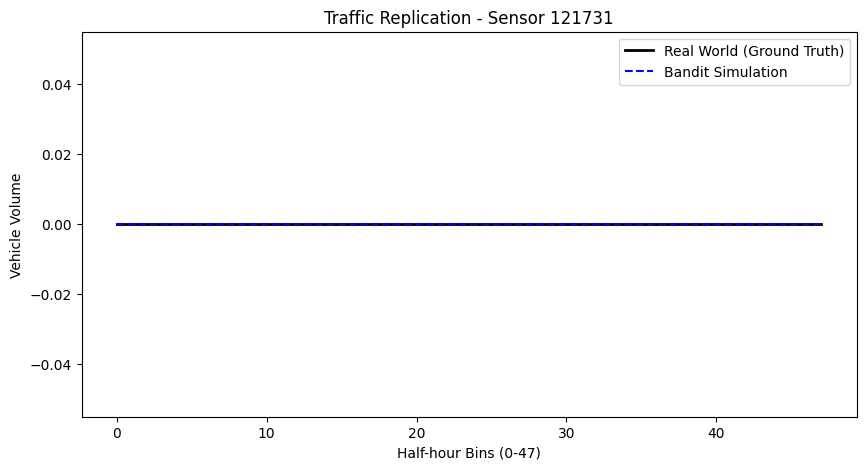

In [51]:
run_demo()